In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from image2image_io.readers import get_simple_reader
from image2image_io.readers._czi import CziFile, get_czi_thumbnail
from image2image_io.readers.czi_reader import CziImageReader
from image2image_io.writers import write_ome_tiff_from_array
from pathlib import Path

import matplotlib.pyplot as plt

In [38]:
path = r"/Users/lgmigas/Documents/DATA/_AIMS_WORKSHOP/_demo-5-convert-czi_to_ome_tiff/2022_02_11__15_51__0381.czi"
czi = CziImageReader(path, auto_pyramid=False, init_pyramid=False)

In [5]:
czi.xml_metadata()

{'ImageDocument': {'Metadata': {'Experiment': {'RunMode': 'ValidateAndAdaptBeforePerformEnabled,OptimizeBeforePerformEnabled,PreventMissingCalibrationDataInformation,PreventStageXYRestoreAfterExperiment,PreventFocusRestoreAfterExperiment',
    'BeforeHardwareSetting': 'HardwareBefore',
    'AfterHardwareSetting': 'HardwareAfter',
    'ExperimentBlockIndex': '0',
    'IsSegmented': 'false',
    'IsStandardMode': 'true',
    'ImageName': 'D:\\Dave A\\22_02_11_ASM_MICE_1mo_6mo\\2022_02_11__15_51__0381.czi',
    'ImageTransferMode': 'MemoryMappedAndFileStream',
    'AutoSave': {'StorageFolder': 'D:\\Users\\ander103\\Pictures',
     'Name': 'New',
     'IsAutoSubFolder': 'true',
     'IsAutoSubFolderExternal': 'true',
     'IsClosedOnCompletion': 'false',
     'SingleFileSaveFormat': 'JPG',
     'ConvertTo8Bit': 'false',
     'AddXmlMetadata': 'false',
     'ApplyDisplayMappings': 'false',
     'SaveOriginalData': 'true',
     'UseChannelNames': 'false',
     'Quality': '90',
     'Compress

In [11]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

import numpy as np
import xml.etree.ElementTree as ET
from czifile import CziFile


@dataclass
class ScenePlacement:
    scene: int
    x0: int
    y0: int
    w: int
    h: int


def _strip_ns(tag: str) -> str:
    """Strip XML namespace from tag."""
    return tag.rsplit("}", 1)[-1] if "}" in tag else tag


def _find_first_text(root: ET.Element, path_suffix: str) -> Optional[str]:
    """
    Find first element whose 'namespace-stripped path' ends with path_suffix,
    and return its text.
    """
    # Build all element paths by walking (simple + robust)
    stack = [(root, _strip_ns(root.tag))]
    while stack:
        node, path = stack.pop()
        if path.endswith(path_suffix):
            if node.text is not None:
                t = node.text.strip()
                if t:
                    return t
        for child in list(node):
            stack.append((child, path + "/" + _strip_ns(child.tag)))
    return None


def _get_pixel_size_um_from_metadata(metadata_xml: str) -> Tuple[float, float]:
    """
    Tries common Zeiss metadata locations for pixel size.
    Returns (px_x_um, px_y_um). Falls back to (1.0, 1.0) if missing.
    """
    root = ET.fromstring(metadata_xml)

    # Common Zeiss patterns include Distance Id="X"/"Y" with <Value> in meters
    # We'll scan all Distance elements and use their Id.
    px_x_um = None
    px_y_um = None

    for elem in root.iter():
        if _strip_ns(elem.tag) != "Distance":
            continue
        id_ = elem.attrib.get("Id") or elem.attrib.get("id")
        if not id_:
            continue
        # Value may be in child <Value> or attribute
        val = None
        for child in list(elem):
            if _strip_ns(child.tag) == "Value" and child.text:
                val = child.text.strip()
                break
        if val is None and elem.text:
            val = elem.text.strip()

        try:
            meters = float(val) if val is not None else None
        except Exception:
            meters = None

        if meters is None:
            continue

        um = meters * 1e6
        if id_.upper() == "X":
            px_x_um = um
        elif id_.upper() == "Y":
            px_y_um = um

    return (px_x_um or 1.0, px_y_um or 1.0)


def _extract_scene_positions_um(metadata_xml: str) -> List[Tuple[float, float]]:
    """
    Extracts per-scene (X_um, Y_um) positions.

    Because Zeiss CZI metadata varies, we try multiple strategies:
      - Tiles/Tile/PositionX/PositionY (meters)
      - Tile/StagePosition/X, Tile/StagePosition/Y (meters)
      - Any repeated StagePosition blocks with X/Y (meters), using order as scenes

    Returns a list of positions in micrometers.
    If we can't find anything reliable, returns an empty list.
    """
    root = ET.fromstring(metadata_xml)

    def text_of_child(parent: ET.Element, child_name: str) -> Optional[str]:
        for ch in list(parent):
            if _strip_ns(ch.tag) == child_name and ch.text:
                t = ch.text.strip()
                if t:
                    return t
        return None

    positions: List[Tuple[float, float]] = []

    # Strategy A: look for <Tile> blocks
    tiles = [e for e in root.iter() if _strip_ns(e.tag) == "Tile"]
    for tile in tiles:
        # Try PositionX/PositionY (often meters)
        px = text_of_child(tile, "PositionX")
        py = text_of_child(tile, "PositionY")

        # Try nested <StagePosition><X>..</X><Y>..</Y>
        if px is None or py is None:
            for ch in list(tile):
                if _strip_ns(ch.tag) == "StagePosition":
                    sx = text_of_child(ch, "X")
                    sy = text_of_child(ch, "Y")
                    if sx is not None and sy is not None:
                        px, py = sx, sy
                        break

        if px is None or py is None:
            continue

        try:
            x_um = float(px) * 1e6
            y_um = float(py) * 1e6
        except Exception:
            continue

        positions.append((x_um, y_um))

    if positions:
        return positions

    # Strategy B: repeated <StagePosition> blocks in document order
    stage_positions = [e for e in root.iter() if _strip_ns(e.tag) == "StagePosition"]
    for sp in stage_positions:
        sx = None
        sy = None
        for ch in list(sp):
            if _strip_ns(ch.tag) == "X" and ch.text:
                sx = ch.text.strip()
            elif _strip_ns(ch.tag) == "Y" and ch.text:
                sy = ch.text.strip()
        if sx is None or sy is None:
            continue
        try:
            positions.append((float(sx) * 1e6, float(sy) * 1e6))
        except Exception:
            pass

    return positions


def _scene_to_cyx(scene: np.ndarray, expected_c: Optional[int] = None) -> np.ndarray:
    """
    Convert a scene array to (C, Y, X).
    czifile can return many shapes; we try to normalize for typical cases.
    """
    a = np.asarray(scene)

    # Remove singleton dims
    a = np.squeeze(a)

    if a.ndim == 2:
        a = a[None, ...]  # (1, Y, X)
        return a

    if a.ndim == 3:
        # Ambiguous: could be (C,Y,X) or (Y,X,C)
        if expected_c is not None:
            if a.shape[0] == expected_c:
                return a
            if a.shape[-1] == expected_c:
                return np.moveaxis(a, -1, 0)

        # Heuristic: channel axis usually small
        if a.shape[0] <= 16 and a.shape[1] > 32 and a.shape[2] > 32:
            return a  # (C, Y, X)
        if a.shape[-1] <= 16 and a.shape[0] > 32 and a.shape[1] > 32:
            return np.moveaxis(a, -1, 0)  # (Y, X, C) -> (C, Y, X)

        # Last resort: assume first axis is C
        return a

    raise ValueError(f"Unsupported scene ndim={a.ndim} shape={a.shape}")


def stitch_czi_scenes_czifile(
    path: str,
    *,
    take_max_on_overlap: bool = True,
    dtype: Optional[np.dtype] = None,
) -> Tuple[np.ndarray, Dict[int, ScenePlacement]]:
    """
    Stitch multi-scene CZI into a single image in a shared coordinate space.

    Returns:
      stitched: (C, Y, X)
      placements: scene -> placement info (x0,y0,w,h) in stitched pixel coordinates
    """
    with CziFile(path) as czi:
        metadata_xml = czi.metadata()  # XML string
        px_x_um, px_y_um = _get_pixel_size_um_from_metadata(metadata_xml)

        # Positions (um) in scene order (best-effort)
        positions_um = _extract_scene_positions_um(metadata_xml)

        # Read the data. For multi-scene CZIs, czifile commonly exposes an "S" dimension.
        data = czi.asarray()  # may be large; if memory is an issue, we can iterate differently

    data = np.asarray(data)

    # Identify scene axis:
    # Common patterns include:
    #   (S, C, Y, X)
    #   (S, Y, X, C)
    #   (S, 1, C, 1, Y, X, 1) ... etc
    # We’ll iterate scenes by indexing the first axis if it looks like S.
    # If your data isn't arranged with S first, tell me the `data.shape` and I’ll adapt.
    if data.ndim < 3:
        raise ValueError(f"Unexpected CZI array shape: {data.shape}")

    n_scenes = data.shape[0]  # assume S=0th axis
    # Grab scene 0 to determine channels
    s0 = _scene_to_cyx(data[0])
    C = s0.shape[0]
    dtype = dtype or s0.dtype

    # If positions are missing, fall back to (0,0) for all scenes
    if len(positions_um) < n_scenes:
        positions_um = positions_um + [(0.0, 0.0)] * (n_scenes - len(positions_um))
    positions_um = positions_um[:n_scenes]

    # Use scene 0 as origin
    x0_um_ref, y0_um_ref = positions_um[0]

    # First pass: compute bounds
    infos: Dict[int, ScenePlacement] = {}
    min_x = 10**18
    min_y = 10**18
    max_x = -10**18
    max_y = -10**18

    scenes_cyx: List[np.ndarray] = []

    for s in range(n_scenes):
        img = _scene_to_cyx(data[s], expected_c=C).astype(dtype, copy=False)
        if img.shape[0] != C:
            raise ValueError(f"Scene {s}: channel mismatch {img.shape[0]} vs {C}")

        h, w = img.shape[1], img.shape[2]
        x_um, y_um = positions_um[s]

        dx_um = x_um - x0_um_ref
        dy_um = y_um - y0_um_ref

        x0_px = int(np.round(dx_um / px_x_um)) if px_x_um else 0
        y0_px = int(np.round(dy_um / px_y_um)) if px_y_um else 0

        infos[s] = ScenePlacement(scene=s, x0=x0_px, y0=y0_px, w=w, h=h)
        scenes_cyx.append(img)

        min_x = min(min_x, x0_px)
        min_y = min(min_y, y0_px)
        max_x = max(max_x, x0_px + w)
        max_y = max(max_y, y0_px + h)

    # Shift to positive coordinates
    shift_x = -min_x
    shift_y = -min_y
    out_w = int(max_x - min_x)
    out_h = int(max_y - min_y)

    stitched = np.zeros((C, out_h, out_w), dtype=dtype)

    # Second pass: paste
    for s, img in enumerate(scenes_cyx):
        info = infos[s]
        x0 = info.x0 + shift_x
        y0 = info.y0 + shift_y

        target = stitched[:, y0 : y0 + info.h, x0 : x0 + info.w]
        if take_max_on_overlap:
            np.maximum(target, img, out=target)
        else:
            target[...] = img

        infos[s] = ScenePlacement(scene=s, x0=x0, y0=y0, w=info.w, h=info.h)

    return stitched, infos


def _scene_to_cyx(
    scene: np.ndarray,
    expected_c: Optional[int] = None,
    *,
    z: Optional[int] = 0,
    z_reduce: str = "max",  # "max" | "mean" | "sum"
) -> np.ndarray:
    """
    Convert a scene array to (C, Y, X).

    Supports:
      - (Y, X)
      - (C, Y, X) or (Y, X, C)
      - (C, Z, Y, X) or (Z, C, Y, X)
      - (C, T, Y, X) similarly (treated like Z)

    Parameters
    ----------
    z:
      If not None, select this plane along the non-spatial axis (Z/T).
      If None, reduce along that axis using z_reduce.
    z_reduce:
      Reduction method when z is None.
    """
    a = np.asarray(scene)
    a = np.squeeze(a)

    # 2D -> (1, Y, X)
    if a.ndim == 2:
        return a[None, ...]

    # 3D: (C,Y,X) or (Y,X,C)
    if a.ndim == 3:
        if expected_c is not None:
            if a.shape[0] == expected_c:
                return a
            if a.shape[-1] == expected_c:
                return np.moveaxis(a, -1, 0)

        # heuristic: channel axis small
        if a.shape[0] <= 32 and a.shape[1] > 32 and a.shape[2] > 32:
            return a
        if a.shape[-1] <= 32 and a.shape[0] > 32 and a.shape[1] > 32:
            return np.moveaxis(a, -1, 0)

        # fallback assume first axis is C
        return a

    # 4D: likely (C,Z,Y,X) or (Z,C,Y,X)
    if a.ndim == 4:
        # Identify which axes are spatial (largest two, usually Y and X)
        # Here we assume last two are (Y, X) which matches your shape (..., 26286, 69983)
        Y, X = a.shape[-2], a.shape[-1]

        # Remaining two axes are (A, B) where one is C and the other is Z/T
        A, B = a.shape[0], a.shape[1]

        # Decide which is C
        if expected_c is not None:
            if A == expected_c:
                # (C, Z, Y, X)
                cz = a
            elif B == expected_c:
                # (Z, C, Y, X) -> (C, Z, Y, X)
                cz = np.moveaxis(a, 1, 0)  # bring C to axis 0
            else:
                # Can't match expected_c; try heuristic (small axis is C)
                c_axis = 0 if A <= B else 1
                cz = a if c_axis == 0 else np.moveaxis(a, 1, 0)
        else:
            # heuristic: smaller of (A,B) is channels
            c_axis = 0 if A <= B else 1
            cz = a if c_axis == 0 else np.moveaxis(a, 1, 0)

        # now cz is (C, Z, Y, X)
        if z is not None:
            return cz[:, z, :, :]
        else:
            if z_reduce == "max":
                return cz.max(axis=1)
            if z_reduce == "mean":
                return cz.mean(axis=1)
            if z_reduce == "sum":
                return cz.sum(axis=1)
            raise ValueError(f"Unknown z_reduce={z_reduce!r}")

    raise ValueError(f"Unsupported scene ndim={a.ndim} shape={a.shape}")

In [12]:
stitched, info = stitch_czi_scenes_czifile(path)

In [28]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Dict, Optional, Tuple, List

import numpy as np
from czifile import CziFile


@dataclass
class ScenePlacement:
    scene: int
    x0: int
    y0: int
    w: int
    h: int


def _get_axis_index(axes: str, key: str) -> Optional[int]:
    try:
        return axes.index(key)
    except ValueError:
        return None


def _reduce_z(a: np.ndarray, axes: str, z: Optional[int], z_reduce: str) -> Tuple[np.ndarray, str]:
    zi = _get_axis_index(axes, "Z")
    if zi is None:
        return a, axes

    if z is not None:
        a = np.take(a, indices=z, axis=zi)
        axes = axes[:zi] + axes[zi + 1 :]
        return a, axes

    if z_reduce == "max":
        a = a.max(axis=zi)
    elif z_reduce == "mean":
        a = a.mean(axis=zi)
    elif z_reduce == "sum":
        a = a.sum(axis=zi)
    else:
        raise ValueError(f"Unknown z_reduce={z_reduce!r}")
    axes = axes[:zi] + axes[zi + 1 :]
    return a, axes


def _to_cyx(scene: np.ndarray, axes: str) -> np.ndarray:
    """
    Convert an array with axes containing C,Y,X (and maybe others already removed)
    into (C,Y,X).
    """
    # S and Z should already be removed at this point
    # We'll squeeze leftover singleton dims.
    scene = np.squeeze(scene)

    # Recompute axes after squeeze is hard; instead, just move the known axes
    # based on current 'axes' string length. We'll do a safer approach:
    # build a list of axes present and then move them.
    # If squeeze removed dims, assume they were singleton non-CYX dims.
    # So we first try to locate C/Y/X positions in the *unsqueezed* scene.

    # Best approach: move axes before squeezing.
    # We'll implement it here: if scene ndim matches len(axes), use that.
    if scene.ndim != len(axes):
        # fallback: handle common simple cases
        if scene.ndim == 2:
            return scene[None, ...]  # (1,Y,X)
        if scene.ndim == 3:
            # assume already (C,Y,X) or (Y,X,C)
            if scene.shape[0] <= 32:
                return scene
            return np.moveaxis(scene, -1, 0)
        raise ValueError(f"Cannot align axes={axes!r} with scene.ndim={scene.ndim}, shape={scene.shape}")

    ci = _get_axis_index(axes, "C")
    yi = _get_axis_index(axes, "Y")
    xi = _get_axis_index(axes, "X")
    if yi is None or xi is None:
        raise ValueError(f"Need Y and X axes, got axes={axes!r}")

    if ci is None:
        # no C axis -> single channel
        # move Y,X to the end then add C=1
        perm = [i for i in range(scene.ndim) if i not in (yi, xi)] + [yi, xi]
        scene2 = np.transpose(scene, perm)
        scene2 = scene2[None, ...]  # (1, Y, X) plus any leftover dims (shouldn't happen)
        if scene2.ndim != 3:
            # collapse any leftover dims
            scene2 = scene2.reshape((1,) + scene2.shape[-2:])
        return scene2

    # Permute to (C, Y, X) dropping any other dims by flattening them (should be singleton)
    perm = [ci, yi, xi] + [i for i in range(scene.ndim) if i not in (ci, yi, xi)]
    scene2 = np.transpose(scene, perm)

    # If there are extra dims left, they should be 1; squeeze them away
    scene2 = np.squeeze(scene2)

    if scene2.ndim == 2:
        scene2 = scene2[None, ...]
    if scene2.ndim != 3:
        raise ValueError(f"After reordering expected (C,Y,X), got {scene2.shape}")

    return scene2


def stitch_czi_scenes_czifile(
    path: str,
    *,
    positions_px: Optional[List[Tuple[int, int]]] = None,
    take_max_on_overlap: bool = True,
    z: Optional[int] = 0,
    z_reduce: str = "max",
) -> Tuple[np.ndarray, Dict[int, ScenePlacement]]:
    """
    Stitches scenes using the CZI array's explicit axes.
    NOTE: 'positions_px' is optional; if None, scenes are placed in a row (debug default).
          If you already have positions in the same coordinate space, pass them as pixel offsets.
    """
    with CziFile(path) as czi:
        data = czi.asarray()
        axes = getattr(czi, "axes", None)
        if axes is None:
            raise ValueError("Your czifile version doesn't expose czi.axes; upgrade czifile or provide axis order manually.")

    axes = axes.replace(" ", "")
    si = _get_axis_index(axes, "S")
    if si is None:
        # no scene axis; treat whole image as one scene
        si = None
        n_scenes = 1
    else:
        n_scenes = data.shape[si]

    # Debug fallback placement if you don't provide positions yet
    if positions_px is None:
        positions_px = [(0, 0)]
        if n_scenes > 1:
            # lay them out side-by-side just so you can verify channels are correct
            positions_px = [(i * 1000, 0) for i in range(n_scenes)]  # placeholder spacing

    if len(positions_px) != n_scenes:
        raise ValueError(f"positions_px must have length {n_scenes}, got {len(positions_px)}")

    scenes_cyx: List[np.ndarray] = []
    infos: Dict[int, ScenePlacement] = {}

    # First pass: compute bounds
    min_x = 10**18
    min_y = 10**18
    max_x = -10**18
    max_y = -10**18

    for s in range(n_scenes):
        a = data
        ax = axes

        # pick scene
        if si is not None:
            a = np.take(a, indices=s, axis=si)
            ax = ax[:si] + ax[si + 1 :]

        # handle Z if present
        a, ax = _reduce_z(a, ax, z=z, z_reduce=z_reduce)

        img = _to_cyx(a, ax)
        scenes_cyx.append(img)

        C, H, W = img.shape
        x0, y0 = positions_px[s]

        infos[s] = ScenePlacement(scene=s, x0=x0, y0=y0, w=W, h=H)
        min_x = min(min_x, x0)
        min_y = min(min_y, y0)
        max_x = max(max_x, x0 + W)
        max_y = max(max_y, y0 + H)

    # shift to positive
    shift_x = -min_x
    shift_y = -min_y
    out_w = max_x - min_x
    out_h = max_y - min_y

    C = scenes_cyx[0].shape[0]
    stitched = np.zeros((C, out_h, out_w), dtype=scenes_cyx[0].dtype)

    # paste
    for s, img in enumerate(scenes_cyx):
        info = infos[s]
        x0 = info.x0 + shift_x
        y0 = info.y0 + shift_y
        target = stitched[:, y0 : y0 + info.h, x0 : x0 + info.w]

        if take_max_on_overlap:
            np.maximum(target, img, out=target)
        else:
            target[...] = img

        infos[s] = ScenePlacement(scene=s, x0=x0, y0=y0, w=info.w, h=info.h)

    return stitched, infos

In [29]:
stitched, info = stitch_czi_scenes_czifile(path)
info

{0: ScenePlacement(scene=0, x0=0, y0=0, w=69983, h=26286),
 1: ScenePlacement(scene=1, x0=1000, y0=0, w=69983, h=26286),
 2: ScenePlacement(scene=2, x0=2000, y0=0, w=69983, h=26286)}

In [40]:
from image2image_io.writers.merge_czi import stitch_czi_scenes_czifile

In [41]:
stitched, info = stitch_czi_scenes_czifile(path, scenes=(0, 2))
info

{0: ScenePlacement(scene=0, x0=0, y0=0, w=69983, h=26286),
 2: ScenePlacement(scene=2, x0=1000, y0=0, w=69983, h=26286)}

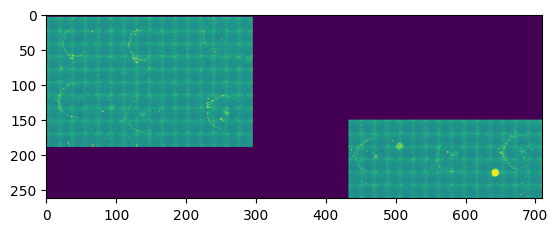

In [42]:
plt.imshow(stitched[2, ::100, ::100], vmax=300)

In [39]:
write_ome_tiff_from_array(
    Path(path).parent / "stitched_from_czifile.ome.tiff",
    reader=None,
    array=stitched,
    resolution=czi.resolution,
    channel_names=czi.channel_names,
)

2025-12-19 14:30:51.763 | INFO     | image2image_io.writers.tiff_writer:_prepare_tiff:241 - Saving to '/Users/lgmigas/Documents/DATA/_AIMS_WORKSHOP/_demo-5-convert-czi_to_ome_tiff/stitched_from_czifile.ome.tiff'
2025-12-19 14:30:51.765 | INFO     | image2image_io.writers.tiff_writer:_prepare_tiff:242 - Using reader: ArrayImageReader<''; PosixPath('.'); RGB=False; (4, 26286, 71983) @ 0.6500>
2025-12-19 14:30:51.765 | INFO     | image2image_io.writers.tiff_writer:_prepare_tiff:243 - Using transformer: None
2025-12-19 14:30:51.766 | INFO     | image2image_io.writers.tiff_writer:_prepare_image_info:217 - Saving using deflate compression. Datatype: uint16 (as_uint8=False)
Writing channels...: 100%|██████████| 4/4 [00:37<00:00,  9.47s/it]


PosixPath('/Users/lgmigas/Documents/DATA/_AIMS_WORKSHOP/_demo-5-convert-czi_to_ome_tiff/stitched_from_czifile.ome.tiff')

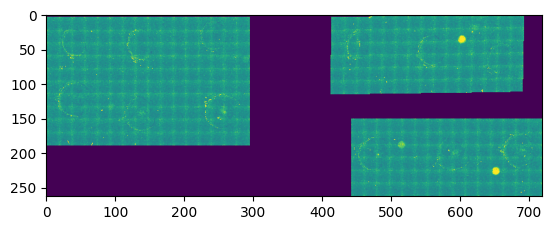

In [37]:
plt.imshow(stitched[2, ::100, ::100], vmax=300)